<a href="https://colab.research.google.com/github/greenteausa/DATA606_Capstone/blob/main/Capstone_Stage_III/Capstone_point_cloud_transformer_Jinqing_Liang_P3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import library

In [ ]:
import numpy as np
import math
import random
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
#import argparse
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import scipy.spatial.distance
from torch.utils.data import DataLoader, Dataset 

import torchvision 
from torchvision import transforms, utils

#from pointnet2_ops import pointnet2_utils
import time 

import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import seaborn as sns
import torch.nn.functional as nnf
import glob
import h5py
#random.seed = 42
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.backends.cudnn.deterministic=True

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Load Dataset

In [ ]:
pointbiggerthan500df_train = pd.read_csv('/content/gdrive/MyDrive/Capstone_606/IntrA/generated/ad/train_df.csv')
pointbiggerthan500df_test = pd.read_csv('/content/gdrive/MyDrive/Capstone_606/IntrA/generated/ad/test_df.csv')

### Final Normalize

In [ ]:
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

### Sample points

In [ ]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, point):
        verts = point
        verts = np.array(verts)
        #areas = np.zeros((len(faces)))

        #for i in range(len(areas)):
        #    areas[i] = (self.triangle_area(verts[faces[i][0]],
        #                                   verts[faces[i][1]],
        #                                   verts[faces[i][2]]))
            
        #sampled_faces = (random.choices(faces, 
        #                              weights=areas,
        #                              cum_weights=None,
        #                              k=self.output_size))
        
        #sampled_points = np.zeros((self.output_size, 3))

        #for i in range(len(sampled_faces)):
        #    sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
        #                                           verts[sampled_faces[i][1]],
        #                                           verts[sampled_faces[i][2]]))
        
        sampled_points = (random.choices(verts, 
                                      #weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        return np.array(sampled_points)
    

### Add random rotation of the whole pointcloud and random noise to its points.

In [ ]:
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

### ToTensor

In [ ]:
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

### Default_transforms for validation and test dataset

In [ ]:
def default_transforms(): # for data augmentaiton.
    return transforms.Compose([
                                PointSampler(500),
                                Normalize(),
                                ToTensor()
                              ])

### Transformation for train dataset

In [ ]:
train_transforms = transforms.Compose([
                    PointSampler(500),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ]) # for data training.

### PointCloudDataBal(for data upsampling).

In [ ]:
class PointCloudDataBal(Dataset):
    def __init__(self, df, valid=False, transform=default_transforms()):
        
        self.classes = {"vessel": 0, "aneurysm": 1}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        #self.files = []
        # create a new dataframe
        self.files = df
        self.files_train = self.files.sample(frac = 0.8)
        #self.files_train = self.__balance_data(self.files_train)
        self.files_valid = self.files.drop(self.files_train.index)
        self.files_train = self.__balance_data(self.files_train)
        self.files_valid = self.__balance_data(self.files_valid)

    def __balance_data(self, data_table):
        from sklearn.utils import resample
        n_samples_major = len(data_table[data_table.classification=='vessel'])
        df_majority = data_table[data_table.classification=='vessel']
        df_minority = data_table[data_table.classification=='aneurysm']

        # Upsample minority class
        df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=n_samples_major,    # to match majority class
                                 random_state=42) # reproducible results
        print(len(df_minority_upsampled))
        # Combine majority class with upsampled minority class
        df_upsampled = pd.concat([df_majority, df_minority_upsampled])
        return df_upsampled
    
    def __len__(self):
        if self.valid == False:
          return len(self.files_train)
        else:
          return len(self.files_valid)

    def __load_ad_file(self, path):
        points = []
        labels = []
        normals = []
        #print(path)
        with open(path, 'r') as f:
            for line in f.readlines():
                s_line = line.split()
                points.append([float(s_line[0]), float(s_line[1]), float(s_line[2])])
                normals.append([float(s_line[3]), float(s_line[4]), float(s_line[5])])
                labels.append(int(s_line[6]))

        return points, labels, normals

    def __preproc__(self, file):
        """for preprocessing."""
        points, labels, normals = self.__load_ad_file(file)
        points = np.array(points)
        if self.transforms:
            pointcloud = self.transforms(points)
        return pointcloud

    def __getitem__(self, idx):
        if self.valid == False:
          pcd_path = self.files_train.iloc[idx]['path'] # check if [idx] here is true for framework.
          category = self.files_train.iloc[idx]['classification']
        else:
          #print(idx)
          pcd_path = self.files_valid.iloc[idx]['path']
          category = self.files_valid.iloc[idx]['classification']
        
        pointcloud = self.__preproc__(pcd_path)
        return pointcloud, self.classes[category]

Check train and valid dataset size and put them to Dataloader.

In [ ]:
train_ds = PointCloudDataBal(pointbiggerthan500df_train, transform=train_transforms)
valid_ds = PointCloudDataBal(pointbiggerthan500df_train, valid=True, transform=default_transforms)#upscaled.

1094
279
1094
279


In [ ]:
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=5)

## Clone the library

In [ ]:
!git clone https://github.com/uyzhang/PCT_Pytorch.git

Cloning into 'PCT_Pytorch'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 113 (delta 41), reused 66 (delta 11), pack-reused 0
Receiving objects: 100% (113/113), 10.24 MiB | 30.47 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [ ]:
!pip install PCT_Pytorch/pointnet2_ops_lib/. 

Processing ./PCT_Pytorch/pointnet2_ops_lib
  Created wheel for pointnet2-ops: filename=pointnet2_ops-3.0.0-cp37-cp37m-linux_x86_64.whl size=5420029 sha256=4600148657690c9ab1de3cad571966d4195a6620fc43bcdb5b8636e7ec85bcaa
  Stored in directory: /tmp/pip-ephem-wheel-cache-aw8vesl_/wheels/81/8e/37/f6ef9f8b3fee67c2c7fa79f19112b3d36b464506d2716f8dbc
Successfully built pointnet2-ops


In [ ]:
from pointnet2_ops import pointnet2_utils

### Cal_loss,square_distance, index_points, knn_point, sample_and_group

In [ ]:
# main.py 
#xp_name=train 
#num_points=1024 
#use_sgd=True 
#batch_size 32 
#epochs 250 
#lr 0.0001

def cal_loss(pred, gold, smoothing=True):
    ''' Calculate cross entropy loss, apply label smoothing if needed. '''
     
    gold = gold.contiguous().view(-1)  #gold is ground truth.

    if smoothing:
        eps = 0.2
        n_class = pred.size(1)
        #https://codesuche.com/python-examples/torch.zeros_like.scatter/
        # Generate one-hot matrix: N x C.
        # Only label position is 1 and all other positions are 0
        # gold include -1 value (IGNORE_ID) and this will lead to assert error.
        #Tensor.scatter_(dim, index, src, reduce=None) → Tensor
        one_hot = torch.zeros_like(pred).scatter(1, gold.view(-1, 1), 1) #https://pytorch.org/docs/master/generated/torch.Tensor.scatter_.html#torch.Tensor.scatter_
        one_hot = one_hot * (1 - eps) + (1 - one_hot) * eps / (n_class - 1)
        log_prb = F.log_softmax(pred, dim=1)

        loss = -(one_hot * log_prb).sum(dim=1).mean()
    else:
        loss = F.cross_entropy(pred, gold, reduction='mean')

    return loss


def square_distance(src, dst):
    """
    Calculate Euclid distance between each two points(n,m).
    src^T * dst = xn * xm + yn * ym + zn * zm；
    sum(src^2, dim=-1) = xn*xn + yn*yn + zn*zn;
    sum(dst^2, dim=-1) = xm*xm + ym*ym + zm*zm;
    dist = (xn - xm)^2 + (yn - ym)^2 + (zn - zm)^2
         = sum(src**2,dim=-1)+sum(dst**2,dim=-1)-2*src^T*dst
    Input:
        src: source points, [B, N, C]
        dst: target points, [B, M, C]
    Output:
        dist: per-point square distance, [B, N, M]
    """
    B, N, _ = src.shape
    _, M, _ = dst.shape
    dist = -2 * torch.matmul(src, dst.permute(0, 2, 1)) #https://pytorch.org/docs/stable/generated/torch.matmul.html
    dist += torch.sum(src ** 2, -1).view(B, N, 1)
    dist += torch.sum(dst ** 2, -1).view(B, 1, M)
    return dist #Actually it's Euclid distance**2.

def index_points(points, idx):
    """
    Input:
        points: input points data, [B, N, C]
        idx: sample index data, [B, S]
    Return:
        new_points:, indexed points data, [B, S, C]
    """
    device = points.device
    B = points.shape[0]
    view_shape = list(idx.shape)
    view_shape[1:] = [1] * (len(view_shape) - 1)
    repeat_shape = list(idx.shape)
    repeat_shape[0] = 1
    batch_indices = torch.arange(B, dtype=torch.long).to(device).view(view_shape).repeat(repeat_shape)
    new_points = points[batch_indices, idx, :]
    return new_points

def knn_point(nsample, xyz, new_xyz):
    """
    Input:
        nsample: max sample number in local region
        xyz: all points, [B, N, C]
        new_xyz: query points, [B, S, C]
    Return:
        group_idx: grouped points index, [B, S, nsample]
    """
    sqrdists = square_distance(new_xyz, xyz)
    _, group_idx = torch.topk(sqrdists, nsample, dim = -1, largest=False, sorted=False)# https://pytorch.org/docs/stable/generated/torch.topk.html
    return group_idx

def sample_and_group(npoint, radius, nsample, xyz, points):
    """
    Input:
        npoint:
        radius:
        nsample:
        xyz: input points position data, [B, N, 3]
        points: input points data, [B, N, D]
    Return:
        new_xyz: sampled points position data, [B, npoint, nsample, 3]
        new_points: sampled points data, [B, npoint, nsample, 3+D]
    """
    B, N, C = xyz.shape
    S = npoint 
    xyz =  xyz.contiguous() #make the xyz contiguous.
    #fps (farthest point sampling)
    fps_idx = pointnet2_utils.furthest_point_sample(xyz, npoint).long() # [B, npoint]
    new_xyz = index_points(xyz, fps_idx) 
    new_points = index_points(points, fps_idx)
    # new_xyz = xyz[:]
    # new_points = points[:]

    idx = knn_point(nsample, xyz, new_xyz)
    #idx = query_ball_point(radius, nsample, xyz, new_xyz)
    grouped_xyz = index_points(xyz, idx) # [B, npoint, nsample, C] #C mean xyz
    grouped_xyz_norm = grouped_xyz - new_xyz.view(B, S, 1, C)
    grouped_points = index_points(points, idx)
    grouped_points_norm = grouped_points - new_points.view(B, S, 1, -1)
    new_points = torch.cat([grouped_points_norm, new_points.view(B, S, 1, -1).repeat(1, 1, nsample, 1)], dim=-1)
    return new_xyz, new_points

### Model Definition: Local_op, Pct, Point_Transformer_Last, SA_Layer.

In [ ]:
class Local_op(nn.Module):# get local features.
    def __init__(self, in_channels, out_channels):
        super(Local_op, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        b, n, s, d = x.size()  # torch.Size([32, 512, 32, 6]) 
        x = x.permute(0, 1, 3, 2)    
        x = x.reshape(-1, d, s)  
        batch_size, _, N = x.size() #B, -, N
        x = F.relu(self.bn1(self.conv1(x))) # B, D, N
        x = F.relu(self.bn2(self.conv2(x))) # B, D, N
        x = F.adaptive_max_pool1d(x, 1).view(batch_size, -1)
        x = x.reshape(b, n, -1).permute(0, 2, 1) # 
        return x

class Pct(nn.Module):
    def __init__(self, output_channels=2):
        super(Pct, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.gather_local_0 = Local_op(in_channels=128, out_channels=128)
        self.gather_local_1 = Local_op(in_channels=256, out_channels=256)

        self.pt_last = Point_Transformer_Last()

        self.conv_fuse = nn.Sequential(nn.Conv1d(1280, 1024, kernel_size=1, bias=False),
                                    nn.BatchNorm1d(1024),
                                    nn.LeakyReLU(negative_slope=0.2))


        self.linear1 = nn.Linear(1024, 512, bias=False)
        self.bn6 = nn.BatchNorm1d(512)
        self.dp1 = nn.Dropout(p=0.5)
        self.linear2 = nn.Linear(512, 256)
        self.bn7 = nn.BatchNorm1d(256)
        self.dp2 = nn.Dropout(p=0.5)
        self.linear3 = nn.Linear(256, output_channels)

    def forward(self, x): # for training
        xyz = x.permute(0, 2, 1)
        batch_size, _, _ = x.size()
        # B, D, N
        x = F.relu(self.bn1(self.conv1(x)))
        # B, D, N
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.permute(0, 2, 1)
        new_xyz, new_feature = sample_and_group(npoint=512, radius=0.15, nsample=32, xyz=xyz, points=x)         
        feature_0 = self.gather_local_0(new_feature)
        feature = feature_0.permute(0, 2, 1)#
        new_xyz, new_feature = sample_and_group(npoint=256, radius=0.2, nsample=32, xyz=new_xyz, points=feature) 
        feature_1 = self.gather_local_1(new_feature)

        x = self.pt_last(feature_1)
        x = torch.cat([x, feature_1], dim=1)
        x = self.conv_fuse(x)
        x = F.adaptive_max_pool1d(x, 1).view(batch_size, -1)
        x = F.leaky_relu(self.bn6(self.linear1(x)), negative_slope=0.2)
        x = self.dp1(x)
        x = F.leaky_relu(self.bn7(self.linear2(x)), negative_slope=0.2)
        x = self.dp2(x)
        x = self.linear3(x)

        return x

class Point_Transformer_Last(nn.Module): # Concat
    def __init__(self, channels=256):
    #def __init__(self, args, channels=256):
        super(Point_Transformer_Last, self).__init__()
        #self.args = args
        self.conv1 = nn.Conv1d(channels, channels, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=1, bias=False)

        self.bn1 = nn.BatchNorm1d(channels)
        self.bn2 = nn.BatchNorm1d(channels)

        self.sa1 = SA_Layer(channels)
        self.sa2 = SA_Layer(channels)
        self.sa3 = SA_Layer(channels)
        self.sa4 = SA_Layer(channels)

    def forward(self, x):
        # b, 3, npoint, nsample  
        # conv2d 3 -> 128 channels 1, 1
        # b * npoint, c, nsample 
        # permute reshape
        batch_size, _, N = x.size()

        # B, D, N
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x1 = self.sa1(x)
        x2 = self.sa2(x1)
        x3 = self.sa3(x2)
        x4 = self.sa4(x3)
        x = torch.cat((x1, x2, x3, x4), dim=1)

        return x

class SA_Layer(nn.Module): #Offset-Attension
    def __init__(self, channels):
        super(SA_Layer, self).__init__() 
        self.q_conv = nn.Conv1d(channels, channels // 4, 1, bias=False)
        self.k_conv = nn.Conv1d(channels, channels // 4, 1, bias=False)
        self.q_conv.weight = self.k_conv.weight
        self.q_conv.bias = self.k_conv.bias

        self.v_conv = nn.Conv1d(channels, channels, 1)
        self.trans_conv = nn.Conv1d(channels, channels, 1)
        self.after_norm = nn.BatchNorm1d(channels)
        self.act = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x): #Offset self attention.
        # b, n, c
        x_q = self.q_conv(x).permute(0, 2, 1)#kernal
        # b, c, n
        x_k = self.k_conv(x)# kernal 
        x_v = self.v_conv(x)# kernal
        # b, n, n
        energy = torch.bmm(x_q, x_k) #bmm is the simple batch matrix matrix multiply.matmul is more general as depending on the inputs, it can correspond to dot, mm or bmm.

        attention = self.softmax(energy)
        attention = attention / (1e-9 + attention.sum(dim=1, keepdim=True))
        # b, c, n
        x_r = torch.bmm(x_v, attention)
        x_r = self.act(self.after_norm(self.trans_conv(x - x_r))) # L = D-E
        x = x + x_r  
        return x

## Train

### Train and validation with preset Train dataset and validation dataset, and  collect the train loss and accuracy rate as training process.

In [ ]:
def train_new(epochs=150, lr=0.0001):
    result = pd.DataFrame(columns=['Epoch', 'train_loss', 'valid_acc', 'train_acc', 'valid_loss'])
    train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True, drop_last=True)
    test_loader = DataLoader(dataset=valid_ds, batch_size=5)
    
    device = torch.device("cuda")

    model = Pct().to(device)
    print(str(model))
    model = nn.DataParallel(model)
    opt = optim.SGD(model.parameters(), lr=lr*100, momentum=0.9, weight_decay=5e-4)
    
    scheduler = CosineAnnealingLR(opt, epochs, lr)# SGD, lr,epoch as parameters.
    
    criterion = cal_loss
    best_test_acc = 0

    for epoch in range(epochs):
        scheduler.step()
        train_loss = 0.0
        count = 0.0
        model.train()
        train_pred = []
        train_true = []
        idx = 0 #epoch number
        total_time = 0.0
        for data, label in (train_loader):# train_loader has batch number difined, so it's batch training.
            data, label = data.to(device).float(), label.to(device).squeeze()
            #print(data.shape)
            data = data.permute(0, 2, 1)# B,point number,point dimension (32, 500, 3) => (32,3,500)
            batch_size = data.size()[0]
            opt.zero_grad()# clear the previous gradiant.

            start_time = time.time()
            logits = model(data)#predicted y as logits.
            loss = criterion(logits, label)#Calculate the loss
            loss.backward()#Update weights.
            opt.step() #SGD is adjusting learning rate for each batch.
            end_time = time.time()
            total_time += (end_time - start_time)
            
            # Get the max value from logits as preds.
            #[[0.5, 0.5],
            # [0.2, 0.8],
            # [0.8, 0.2],
            # ..........] 
            preds = logits.max(dim=1)[1] # get the final prediction through the max percentage.
            count += batch_size# calculate the number of samples trained finally. sometimes final batch less than 32 will be dropped.
            train_loss += loss.item() * batch_size # loss.item() is calculate the loss per sample.train loss is each sample times batch number then append every batch.
            train_true.append(label.cpu().numpy())
            train_pred.append(preds.detach().cpu().numpy()) # from GPU to CPU, from tensor to numpy as a list.
            idx += 1
            
        print ('train total time is',total_time)
        train_true = np.concatenate(train_true) # put all the ground truth to a list.
        train_pred = np.concatenate(train_pred) # put all predicted label to a list
        train_acc = metrics.accuracy_score(train_true, train_pred)# accuracy score.
        avg_train_acc = metrics.balanced_accuracy_score(train_true, train_pred) # if the samples are not balanced,will have a balanced accuracy acore.
        outstr = 'Train %d, loss: %.6f, train acc: %.6f, train avg acc: %.6f' % (epoch,
                                                                                train_loss*1.0/count,
                                                                                train_acc,
                                                                                avg_train_acc)
        print(outstr) 

        ####################
        #    Validation   #
        ####################
        test_loss = 0.0
        count = 0.0
        model.eval() # not update the weight. but model.train() will update the weights.
        test_pred = []
        test_true = []
        total_time = 0.0
        for data, label in test_loader:
            data, label = data.to(device).float(), label.to(device).squeeze() # float()(32byte long) is important here. The x, y, z coordinates of point cloud are double(2 8byte long).
            data = data.permute(0, 2, 1)
            batch_size = data.size()[0] #data.size( batch number, sample size(point number), sample dimentional information)
            start_time = time.time() 
            logits = model(data)
            end_time = time.time()
            total_time += (end_time - start_time)
            loss = criterion(logits, label)
            preds = logits.max(dim=1)[1] 
            count += batch_size
            test_loss += loss.item() * batch_size
            test_true.append(label.cpu().numpy())
            test_pred.append(preds.detach().cpu().numpy())
        print ('test total time is', total_time)
        test_true = np.concatenate(test_true) # concatente test_true for every batch
        test_pred = np.concatenate(test_pred) # contatenat test_pred for every batch
        test_acc = metrics.accuracy_score(test_true, test_pred)
        avg_per_class_acc = metrics.balanced_accuracy_score(test_true, test_pred)
        outstr = 'ValidEpoch-%d_loss-%.6f_testAcc-%.6f_testAvgAcc-%.6f' % (epoch,
                                                                            test_loss*1.0/count,
                                                                            test_acc,
                                                                            avg_per_class_acc)
        print(outstr)
        result = result.append({"Epoch": epoch, "train_loss": train_loss*1.0/count, "valid_acc": avg_per_class_acc, 'train_acc': avg_train_acc, 'valid_loss': test_loss*1.0/count}, ignore_index=True)
        if test_acc >= best_test_acc:
            best_test_acc = test_acc
            torch.save(model.state_dict(), 'gdrive/MyDrive/Capstone_606/PCT-models_150/model_%s.t7' % outstr)

    return result

### Put the training and validation to a dataframe and plot show. 

In [ ]:
train_valid_table = train_new()

Pct(
  (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,), bias=False)
  (conv2): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gather_local_0): Local_op(
    (conv1): Conv1d(128, 128, kernel_size=(1,), stride=(1,), bias=False)
    (conv2): Conv1d(128, 128, kernel_size=(1,), stride=(1,), bias=False)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (gather_local_1): Local_op(
    (conv1): Conv1d(256, 256, kernel_size=(1,), stride=(1,), bias=False)
    (conv2): Conv1d(256, 256, kernel_size=(1,), stride=(1,), bias=False)
    (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(256, eps=1e-05, momentum=

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate



train total time is 39.5653121471405
Train 0, loss: 0.736853, train acc: 0.523897, train avg acc: 0.523898
test total time is 1.768815040588379
ValidEpoch-0_loss-0.698379_testAcc-0.612903_testAvgAcc-0.612903
train total time is 39.55528521537781
Train 1, loss: 0.731460, train acc: 0.534007, train avg acc: 0.534035
test total time is 1.764366626739502
ValidEpoch-1_loss-0.671115_testAcc-0.636201_testAvgAcc-0.636201
train total time is 39.5643994808197
Train 2, loss: 0.708829, train acc: 0.594669, train avg acc: 0.594686
test total time is 1.7720422744750977
ValidEpoch-2_loss-0.716931_testAcc-0.559140_testAvgAcc-0.559140
train total time is 39.5610408782959
Train 3, loss: 0.708931, train acc: 0.598805, train avg acc: 0.598805
test total time is 1.7316584587097168
ValidEpoch-3_loss-0.655330_testAcc-0.713262_testAvgAcc-0.713262
train total time is 39.53766489028931
Train 4, loss: 0.695419, train acc: 0.637868, train avg acc: 0.637839
test total time is 1.7218501567840576
ValidEpoch-4_loss-0

### Validation accuracy and loss function.

In [ ]:
train_valid_table

,Epoch,train_loss,valid_acc,train_acc,valid_loss
0,0.0,2.873464,0.612903,0.523898,0.698379
1,1.0,2.852431,0.636201,0.534035,0.671115
2,2.0,2.764179,0.559140,0.594686,0.716931
3,3.0,2.764576,0.713262,0.598805,0.655330
4,4.0,2.711884,0.745520,0.637839,0.639355
...,...,...,...,...,...
145,145.0,2.034547,0.960573,0.978409,0.525738
146,146.0,2.034153,0.965950,0.978865,0.523613
147,147.0,2.031396,0.969534,0.981158,0.520373
148,148.0,2.035548,0.964158,0.980237,0.527211


In [ ]:
train_valid_table.to_csv('/content/gdrive/MyDrive/Capstone_606/IntrA/generated/ad/train_valid_table_PCT_SGD_150.csv')

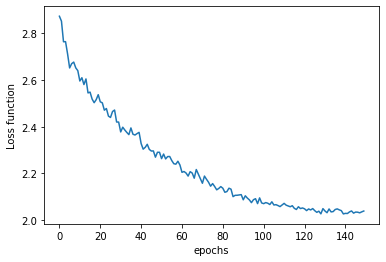

In [ ]:
plt.plot(train_valid_table['Epoch'],train_valid_table['train_loss'])
plt.xlabel("epochs")
plt.ylabel("Loss function")
plt.show()

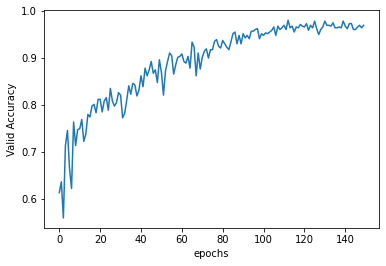

In [ ]:
plt.plot(train_valid_table['Epoch'],train_valid_table['valid_acc'])
plt.xlabel("epochs")
plt.ylabel("Valid Accuracy")
plt.show()

## Test the model with highest accuracy rate.

#### Download the model which has highest validate accuracy.

In [ ]:
model_trained = "/content/gdrive/MyDrive/Capstone_606/PCT-models_150/model_ValidEpoch-112_loss-0.520442_testAcc-0.980287_testAvgAcc-0.980287.t7"

### Test with validation dataset.

In [ ]:
def test_valid(model_path):
    valid_roc = pd.DataFrame(columns=['label', 'pred', 'prob_0', 'prob_1'])
    test_loader = DataLoader(dataset=valid_ds, batch_size=1)

    device = torch.device("cuda")

    model = Pct().to(device)
    model = nn.DataParallel(model) 
    
    model.load_state_dict(torch.load(model_path))
    model = model.eval()
    test_true = []
    test_pred = []

    for data, label in test_loader:
        data, label = data.to(device).float(), label.to(device).squeeze() # float() is important here. The x, y, z coordinates of point cloud are double.
        data = data.permute(0, 2, 1)
        logits = model(data)
        #print(logits)
        preds = logits.max(dim=1)[1] 
        # batch_size = 1
        test_true.append([label.cpu().numpy()])
        test_pred.append([preds.detach().cpu().numpy()])
        #if args.test_batch_size == 1:
        #    test_true.append([label.cpu().numpy()])
        #    test_pred.append([preds.detach().cpu().numpy()])
        #else:
        #    test_true.append(label.cpu().numpy())
        #    test_pred.append(preds.detach().cpu().numpy())
        
        valid_roc = valid_roc.append({"label": label.data.cpu().numpy(), "pred": preds.detach().cpu().numpy(), 
                                      "prob_0": math.exp(logits.data.cpu().numpy()[0][0]), "prob_1": math.exp(logits.data.cpu().numpy()[0][1])}, ignore_index=True)

    test_true = np.concatenate(test_true)
    test_pred = np.concatenate(test_pred)
    test_acc = metrics.accuracy_score(test_true, test_pred)
    avg_per_class_acc = metrics.balanced_accuracy_score(test_true, test_pred)
    outstr = 'Test :: test acc: %.6f, test avg acc: %.6f'%(test_acc, avg_per_class_acc)
    print(outstr)
    return valid_roc

In [ ]:
valid_table = test_valid(model_trained)

Test :: test acc: 0.964158, test avg acc: 0.964158


In [ ]:
valid_table

,label,pred,prob_0,prob_1
0,0,[0],1.681266,0.444249
1,0,[0],1.970321,0.491032
2,0,[0],1.724078,0.482412
3,0,[0],1.584838,0.510387
4,0,[0],1.850644,0.413639
...,...,...,...,...
553,1,[1],0.329231,1.928845
554,1,[1],0.536564,1.435299
555,1,[1],0.475103,1.541288
556,1,[1],0.370817,1.767365


### Check the performance on testing dataset.

In [ ]:
test_df = pd.read_csv('/content/gdrive/My Drive/Capstone_606/IntrA/generated/ad/test_df.csv')
test_index_list = [test_df['Unnamed: 0'].tolist()]

In [ ]:
test_df

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,path,NumberPoint,classification
0,1373,1373,1491,1491,/content/gdrive/My Drive/Capstone_606/IntrA/ge...,1633,vessel
1,925,925,990,990,/content/gdrive/My Drive/Capstone_606/IntrA/ge...,1438,vessel
2,1470,1470,1600,1600,/content/gdrive/My Drive/Capstone_606/IntrA/ge...,687,vessel
3,1369,1369,1486,1486,/content/gdrive/My Drive/Capstone_606/IntrA/ge...,604,vessel
4,858,858,921,921,/content/gdrive/My Drive/Capstone_606/IntrA/ge...,2383,vessel
...,...,...,...,...,...,...,...
169,149,149,149,149,/content/gdrive/My Drive/Capstone_606/IntrA/ge...,1705,aneurysm
170,122,122,122,122,/content/gdrive/My Drive/Capstone_606/IntrA/ge...,1026,aneurysm
171,87,87,87,87,/content/gdrive/My Drive/Capstone_606/IntrA/ge...,944,aneurysm
172,70,70,70,70,/content/gdrive/My Drive/Capstone_606/IntrA/ge...,1787,aneurysm


In [ ]:
class PointCloudDataTest(Dataset):
    def __init__(self, df, valid=True, transform=default_transforms()):
        self.classes = {"vessel": 0, "aneurysm": 1}
        self.transforms = transform
        self.valid = valid
        self.files = df

    def __len__(self):
        print(self.files)
        return len(self.files)

    def __load_ad_file(self, path):
        points = []
        labels = []
        normals = []
        print(path)
        with open(path, 'r') as f:
            for line in f.readlines():
                s_line = line.split()
                points.append([float(s_line[0]), float(s_line[1]), float(s_line[2])])
                normals.append([float(s_line[3]), float(s_line[4]), float(s_line[5])])
                labels.append(int(s_line[6]))

        return points, labels, normals
        
    def __preproc__(self, file):
        points, labels, normals = self.__load_ad_file(file)
        points = np.array(points)
        if self.transforms:
            pointcloud = self.transforms(points)
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files.iloc[idx]['path']
        category = self.files.iloc[idx]['classification']
        
        pointcloud = self.__preproc__(pcd_path)
        return pointcloud, self.classes[category]

In [ ]:
test_ds = PointCloudDataTest(test_df)
test_loader = DataLoader(dataset=test_ds, batch_size=1)

In [ ]:
def test_test(model_path):
    test_roc = pd.DataFrame(columns=['label', 'pred', 'prob_0', 'prob_1'])
    
    device = torch.device("cuda")

    model = Pct().to(device)
    model = nn.DataParallel(model) 
    
    model.load_state_dict(torch.load(model_path))
    model = model.eval()
    test_true = []
    test_pred = []
    with torch.no_grad():
      for data, label in test_loader:
          data, label = data.to(device).float(), label.to(device).squeeze() # float() is important here. The x, y, z coordinates of point cloud are double.
          data = data.permute(0, 2, 1)
          logits = model(data)
          preds = logits.max(dim=1)[1] 
          # batch_size = 1
          test_true.append([label.cpu().numpy()])
          test_pred.append([preds.detach().cpu().numpy()])
          #if args.test_batch_size == 1:
          #    test_true.append([label.cpu().numpy()])
          #    test_pred.append([preds.detach().cpu().numpy()])
          #else:
          #    test_true.append(label.cpu().numpy())
          #    test_pred.append(preds.detach().cpu().numpy())
          
          test_roc = test_roc.append({"label": label.data.cpu().numpy(), "pred": preds.detach().cpu().numpy()[0], 
                                        "prob_0": nnf.softmax(logits, dim=1).data.cpu().numpy()[0][0], "prob_1": nnf.softmax(logits, dim=1).data.cpu().numpy()[0][1]}, ignore_index=True)

    test_true = np.concatenate(test_true)
    test_pred = np.concatenate(test_pred)
    print(test_pred)
    test_acc = metrics.accuracy_score(test_true, test_pred)
    avg_per_class_acc = metrics.balanced_accuracy_score(test_true, test_pred)
    outstr = 'Test :: test acc: %.6f, test avg acc: %.6f'%(test_acc, avg_per_class_acc)
    print(outstr)
    return test_roc

In [ ]:
test_roc = test_test(model_trained)

     Unnamed: 0  Unnamed: 0.1  ...  NumberPoint  classification
0          1373          1373  ...         1633          vessel
1           925           925  ...         1438          vessel
2          1470          1470  ...          687          vessel
3          1369          1369  ...          604          vessel
4           858           858  ...         2383          vessel
..          ...           ...  ...          ...             ...
169         149           149  ...         1705        aneurysm
170         122           122  ...         1026        aneurysm
171          87            87  ...          944        aneurysm
172          70            70  ...         1787        aneurysm
173          14            14  ...         2435        aneurysm

[174 rows x 7 columns]
/content/gdrive/My Drive/Capstone_606/IntrA/generated/ad/vessel_ad/ArteryObjAN212-19.ad
/content/gdrive/My Drive/Capstone_606/IntrA/generated/ad/vessel_ad/ArteryObjAN182-0.ad
/content/gdrive/My Drive/Capstone

### Roc Curve with test dataset

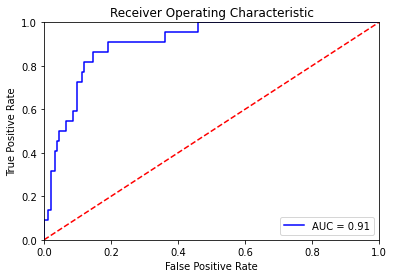

              precision    recall  f1-score   support

    vessel 0       0.96      0.89      0.92       152
  aneurysm 1       0.48      0.73      0.58        22

    accuracy                           0.87       174
   macro avg       0.72      0.81      0.75       174
weighted avg       0.90      0.87      0.88       174



In [ ]:
# calculate the fpr and tpr for all thresholds of the classification
#probs = model.predict_proba(X_test)
#preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(test_roc['label'].astype(int), test_roc['prob_1'])
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

target_names = ['vessel 0', 'aneurysm 1']
print(classification_report(test_roc['label'].astype(int), test_roc['pred'].astype(int), target_names=target_names))